#How to upload an image to Colab?

# Use libraries


In [62]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import io
import os
import cv2 as cv
from PIL import Image
import PIL

# Import the necessary libraries
from PIL import Image
from numpy import asarray

In [63]:
from google.colab import files
from IPython.display import Image

In [58]:
uploaded = files.upload()

Saving Aby_gpp.png to Aby_gpp.png


In [64]:
img = Image('Aby_gpp.png')
print(type(img))

<class 'IPython.core.display.Image'>


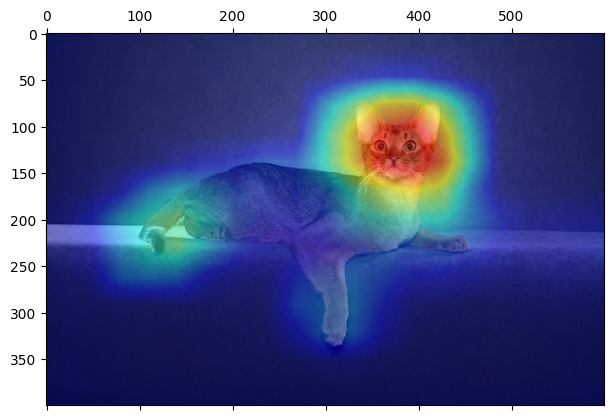

In [66]:
im = plt.imread("Aby_gpp.png")
# fig, ax = plt.subplots()
# im = plt.imshow(im)
plt.matshow(im)
plt.show()
# resized_heat_map = cv.resize(im, dsize= (350,500))
# plt.imshow(resized_heat_map)

In [67]:
import numpy as np
from skimage.measure import label
import tensorflow as tf
import io
from PIL import Image

#Binarize a saliency map using a threshold
def binarize(saliency_map, threshold):
    
    #Get the dimensions of the saliency map
    h, w,e = saliency_map.shape
    
    #The binarized version of the saliency map
    result = np.zeros((h,w))
    
    for i in range(h):
        
        for j in range(w):
            
            if(saliency_map[i][j][0] >= threshold[0]):
                
                result[i][j] = 1
                
    return result

#Donne la valeur moyenne des pixels dans une carte de chaleur
def get_average(saliency_map):
    
    #Les dimensions de la carte de chaleur
    n, m ,k= saliency_map.shape
    
    #La moyenne au départ elle est à 0
    average = 0
    
    #Je somme pour chaque pixel
    for i in range(n):
        
        for j in range(m):
            
            average += saliency_map[i][j]
       
    # ma moyenne c'est la somme divisé par le nombre de pixels
    return average/(n*m)

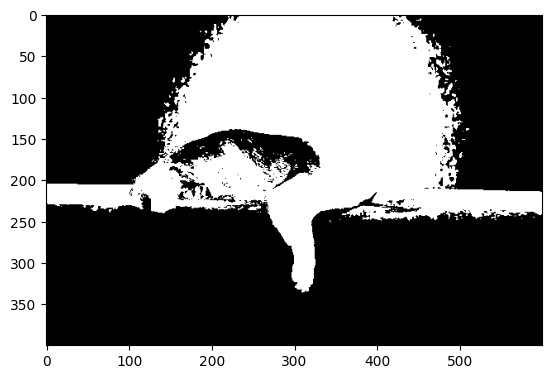

In [68]:
avearge_saliency = get_average(im)
mask = binarize(im, avearge_saliency)
plt.imshow(mask, "gray")


In [69]:
#Retourne la plus grande boite qui entoure la composante connexe
def get_bounding_box(image):
    
    #Dimension de l'image
    n, m = image.shape
    
    #La coordonnée la plus haute
    upper = 0
    
    #La plus petite coordonnée dans l'image
    lower = 0
    
    #La coordonnée la plus à gauche
    left_result = n
    
    #La coordonnée la plus à droite
    right_result = 0
    
    #Pour savoir si la première bande supérieur a été trouvée
    first_bound = True
    
    #Pour chaque ligne
    for i in range(n):
        
        #Je cherhce le pixel le plus à gauche
        left = n
        
        #et le pixel le plus à droite
        right = 0
        
        #et je regarde si la colonne contient au moins un pixel
        contain_pixel = False
        
        #Pour chaque colonne
        for j in range(m):
            
            #Si l'image contient un pixel à 1
            if(image[i][j]) :
                
                #Je sais que je suis à la première colonne
                contain_pixel = True
                
                #Je compare quel pixel et le plus à gauche
                if(j < left):
                
                    left = j
                    
                if(j > right):
                    
                    right = j
                    
        if(left < left_result):
            
            left_result = left
            
        if(right > right_result):
            
            right_result = right
        
        if(contain_pixel and first_bound):
            
            upper = i
            first_bound = False
            
        elif(contain_pixel and not first_bound):
            
            lower = i
            
    return [upper, left_result], abs(left_result-right_result), abs(upper-lower)

def make_matrix(mask, coordinates):
    
    result = np.zeros(mask.shape)
    
    for i in range(coordinates[0][0], coordinates[0][0]+coordinates[2]):
        
        for j in range(coordinates[0][1], coordinates[0][1]+coordinates[1]):
            
            result[i][j] = 1
            
    return result

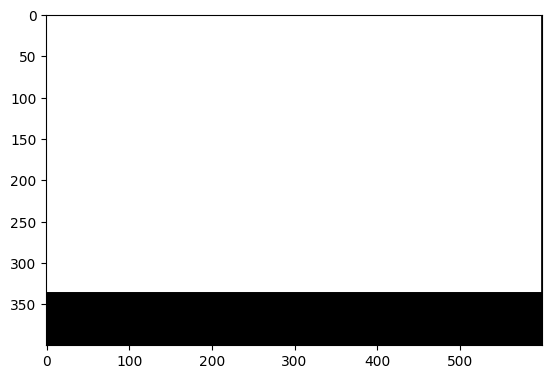

In [70]:
predicted_box = make_matrix(mask, get_bounding_box(mask))
plt.imshow(predicted_box, "gray")

In [42]:
uploaded = files.upload()

In [71]:
def read_trimap(path):
    
    with tf.io.gfile.GFile(path, 'rb') as fid:
        
        encoded_mask_png = fid.read()
    
    encoded_png_io = io.BytesIO(encoded_mask_png)
    
    return np.array(Image.open(encoded_png_io))


#Transform a trimap like the one above into a binary one 
def transform_trimap(trimap):
    
    h, w = trimap.shape
    
    result = []
    
    for i in range(h):
        
        line  = []
        
        for j in range(w):
            
            if(trimap[i][j] == 2):
                
                line.append(0)
                
            else:
                
                line.append(1)
                
        result.append(line)
                
    return np.array(result)

In [72]:
trimap = read_trimap("Abyssinian_1_mask.png")
binary_map = transform_trimap(trimap)
ground_truth_box = make_matrix(binary_map, get_bounding_box(binary_map))

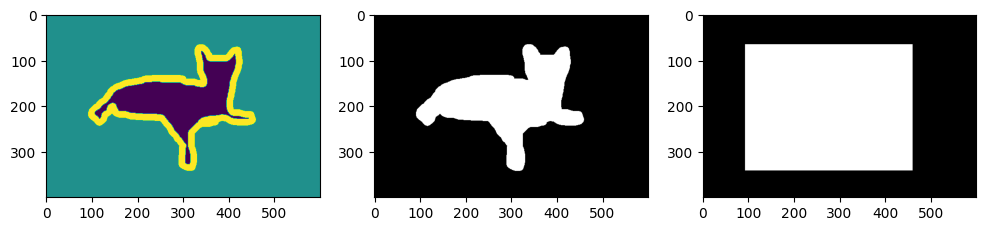

In [73]:
fig, ax = plt.subplots(1, 3, figsize = (12, 12))

ax[0].imshow(trimap)
ax[1].imshow(binary_map, "gray")
ax[2].imshow(ground_truth_box, "gray")

In [74]:
from math import log
from skimage.measure import label
import numpy as np

##The ground_truth (mask/box)  and the predicted (mask/box) must be in a binary format
##Please make sure that the ground_truth (mask/box) exists (the entry must be a matrix that contains at least a pixel with 1 value)
def IoU(ground_truth, predicted_mask):
    
    #verify if the two images has the same dimensions
    # assert ground_truth.shape == predicted_mask.shape
    
    #Get the dimension of the picture
    m, n = ground_truth.shape
    
    #The variable that will contain the value of the intersection of the two masks area
    intersection = 0
    
    #The same but for union
    union = 0
    
    #We iterate on pixels
    for i in range(175):
        
        for j in range(175):
            
            #If the two of pixels is equal to one that mean that the pixel is in both masks
            if(int(ground_truth[i][j]) == 1 and int(predicted_mask[i][j]) == 1):
                
                intersection += 1
                union += 1
             
            #If the pixel is in one of the twos without being in the other we add 1
            if( int(ground_truth[i][j]) == 1 ^ int(predicted_mask[i][j]) == 1):
                
                union += 1
    
    return intersection/union

#Dice coefficient F1 score
#ground truth, preidcted --> (box/mask) must be numpy.array
def DC(ground_truth, predicted):

    #make sure that the dimensions are the same
    # assert ground_truth.shape == predicted.shape

    #Get the dimensions of the matrix
    h, w = ground_truth.shape

    #The number of pixel with 1 as value that are in both of ground_truth and predicted mask or box
    TP = 0
    #The number of pixels that are in the ground_truth but not in the predicted mask or box
    TN = 0
    #The same but for predicted instead of ground truth
    FN = 0

    #We iterate in each pixel in both ground_truth and predicted to see what does match
    for i in range(175):

        for j in range(175):
            
            #We verify if they had 1 pixels in commun (intersection)
            if(int(ground_truth[i][j]) == 1 and int(predicted[i][j]) == 1):

                TP += 1

            #To count the number of pixels "1" that are in ground_truth but not in predicted
            elif(int(ground_truth[i][j]) == 1 and int(predicted[i][j]) == 0):

                FN += 1

            #Same thing but for predicted
            elif(int(ground_truth[i][j]) == 0 and int(predicted[i][j]) == 1):

                TN += 1

    #The dice formula (2*Union/(cardinality(ground_truth)+cardinality(predicted))
    return 2*TP/(2*TP+TN+FN)

#Localization error
def LE(ground_truth, prediction):
    
    return 1-IoU(ground_truth, prediction)


#Energy pointing game it is equivalent to the "Pixel-wise precision"
def EPG(ground_truth_mask, saliency_map):


    # assert ground_truth_mask.shape ==  saliency_map.shape
    
    h, w = ground_truth_mask.shape
    
    #The saliency contained in the ground_truth (mask or box)
    ground_truth_saliency = 0
    
    #The saliency on the hole image
    global_saliency = 0
    
    
    for i in range(175):
        
        for j in range(175):
            
            #We and the value of the saliency when we have a pixel of 1 in the ground_truth
            ground_truth_saliency += float(saliency_map[i][j][0])*int(ground_truth_mask[i][j])
            
            #We sum the saliency of all pixels
            global_saliency += float(saliency_map[i][j][0])

    #The formula of energy pointing game
    return ground_truth_saliency/global_saliency


#The precision for the class of pixels with 1 value
def precision(ground_truth, predicted):
    
    #verify if the dimensions are the same
    # assert ground_truth.shape == predicted.shape
    
    #Get the dimensions of one of the matrices
    h, w = ground_truth.shape
    
    #The well classified pixels
    good_predictions = 0
    
    #The number of pixels with value of one
    hypothesis = 0
    
    for i in range(175):
        
        for j in range(175):

            #If the predicted label correspond to the ground label
            if(ground_truth[i][j] == predicted[i][j] and ground_truth[i][j] == 1):
                
                good_predictions += 1
                
                hypothesis += 1
                
            #If it's not
            elif(predicted[i][j] == 1 and ground_truth[i][j] == 0):
                
                hypothesis += 1
                
    return good_predictions/hypothesis


#The recall of class 1 pixels
def recall(ground_truth, predicted):

    # assert ground_truth.shape == predicted.shape
    
    h, w = ground_truth.shape
    
    #Well classified pixels
    good_predictions = 0
    
    #The number of pixels with 1 as value
    refrences = 0
    
    #Same thing as the precision but we calculate the number of references pixels of ground truth
    for i in range(175):
        
        for j in range(175):
            
            if(ground_truth[i][j] == predicted[i][j] and ground_truth[i][j] == 1):
                
                good_predictions += 1
                refrences += 1
                
            elif(ground_truth[i][j] == 1 and predicted[i][j] == 0):
                
                refrences += 1
                
    return good_predictions/refrences


#The beta F-score 
def F_score(ground_truth, predicted, beta=1):
    
    p = precision(ground_truth, predicted)
    
    r = recall(ground_truth, predicted)
    print(p)
    print(r)
    
    return (1+beta**2)*p*r/((beta**2)*p+r)


#Calculate the fraction of the ground truth  that is covered by the saliency map
def pixel_wise_recall(ground_truth, sallience_map):
    
    # assert ground_truth.shape == sallience_map.shape
    
    m, n = ground_truth.shape
    
    ground_truth_saliency = 0
    
    refrences = 0
    
    for i in range(175):
        
        for j in range(175):
            
            if(int(ground_truth[i][j]) == 1):
                
                refrences += 1
                
                ground_truth_saliency += float(sallience_map[i][j][0])
                
    
    return ground_truth_saliency/refrences


#The F_beta score
def pixel_wise_F_score(ground_truth, saliency_map, beta=1):
    
    p = EPG(ground_truth, saliency_map)
    
    r = pixel_wise_recall(ground_truth, saliency_map)

    return (1+beta**2)*(p*r)/((beta**2)*p+r)


#Calculate the "1" class pixels in a binary mask or box
def get_cardinality(predicted):
    
    h, w = predicted.shape
    
    result = 0
    
    for i in range(h):
        
        for j in range(w):
            
            if(int(predicted[i][j]) == 1):
                
                result += 1
                
    return result

#The saliency metric
def SM(predicted, probability_class):
    
    h, w = predicted.shape
    
    return log( max( 0.05, get_cardinality(predicted) / (h*w) ) ) - log( probability_class )


#The absolute mean error
def AME(saliency_map, ground_truth):
    
    # assert saliency_map.shape == ground_truth.shape
    
    h, w ,v = saliency_map.shape
    
    result = 0
    
    for i in range(175):
        
        for j in range(175):
            
            result += abs(float(saliency_map[i][j][0]) - int(ground_truth[i][j]))
            
    return result/(h*w)

#The mask and box accuaracy it works for both of them
#Max value refer to sigma the second threshold
def accuaracy(ground_truths, saliency_maps, thresholds_list, max_value=0.5):
    
    assert len(ground_truths) == len(saliency_maps)
    
    results = np.zeros((len(thresholds_list),0))
    
    for i in range(len(ground_truths)):
        
        for j in len(thresholds_list):
            
            if(IoU(ground_truths[i], saliency_maps[i]) >= max_value):
                
                results[j] += 1
                
    results = results/len(ground_truths)  
    
    return np.max(results), results



def concept_influence(binary_segmentation_mask, top_k_binary_mask, k = 1_000):
    
    assert binary_segmentation_mask.shape ==  top_k_binary_mask.shape
    
    h, w = binary_segmentation_mask.shape
    
    top_k_binary_mask = 0
    
    relative_size_concept = 0
    
    for i in range(h):
        
        for j in range(w):
            
            top_k_binary_mask += binary_segmentation_mask[i][j]*top_k_binary_mask[i][j]
            
            relative_size_concept += binary_segmentation_mask[i][j]
    
    top_k_binary_mask /= k
    
    return top_k_binary_mask/relative_size_concept

def relevance_rank_accuracy(ground_truth, top_k_pixels):
    
    h, w = ground_truth.shape
    
    result = 0
    
    for pixel in top_k_pixels:
        
        result += ground_truth[pixel[0]][pixel[1]]
        
    return result/(h*w)

In [75]:
LE(ground_truth_box, predicted_box)

0.0

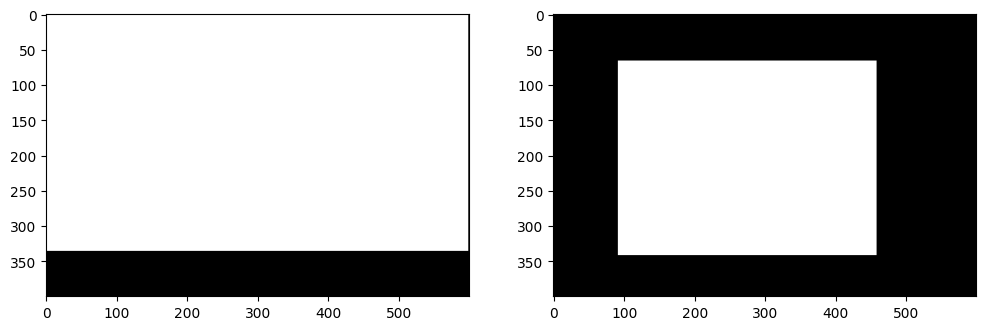

In [76]:
fig, ax = plt.subplots(1, 2, figsize = (12, 12))

ax[0].imshow(predicted_box, "gray")
ax[1].imshow(ground_truth_box, "gray")

In [77]:
LE(binary_map, mask)

0.478494623655914

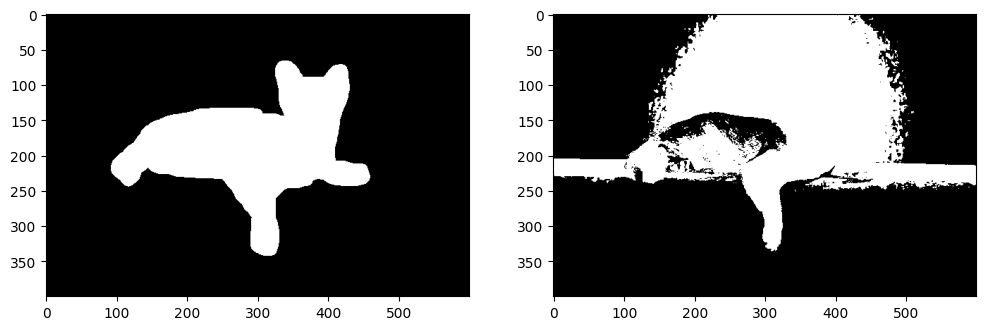

In [78]:
fig, ax = plt.subplots(1, 2, figsize = (12, 12))

ax[0].imshow(binary_map, "gray")
ax[1].imshow(mask, "gray")


In [79]:
1- DC(binary_map, mask)

0.6726290921363483

In [80]:
EPG(binary_map, im)

0.04188488171940425

In [81]:
EPG(ground_truth_box, im)

0.38292999055009713

In [82]:
pixel_wise_F_score(binary_map, im)

0.06721843323045378

In [83]:
pixel_wise_F_score(ground_truth_box, im)

0.22556245747065526

In [84]:
AME(im, ground_truth_box)

0.041380539304809644

In [85]:
AME(im, binary_map)

0.018293889345647768